In [1]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.misc import imresize
import json
import flickrapi as fl

import os, glob

from imageio import imsave

from PIL import Image
import requests
from io import BytesIO

from IPython.display import clear_output

import ipywidgets as widgets

api_key = "0f1d2e9e584fa7bc3f1eab726a91464a"
api_secret = "f75c6c2cd4ae0422"

flickr = fl.FlickrAPI(api_key, api_secret)

flickr_dataset_path = "../flickr_dataset/"

In [2]:
#flickr.photos.licenses.getInfo(format='parsed-json')

In [3]:
#!conda remove nbpresent

In [46]:
SEARCH_TEXT = "material"
PAGE = 1

req_extras = ["owner_name", 
              "tags", 
              "o_dims",
              "url_c", 
              "url_o"]

license_ids = ['2', '3', '4', '5', '6', '7', '9', '10']
license_ids = ','.join(license_ids)


req_extras = ', '.join(req_extras)

res = flickr.photos.search(tags=SEARCH_TEXT,
                           tag_mode='all',
                           license=license_ids,
                           content_type='1', # Only photos
                           media='photos',
                           extras=req_extras,
                           page=PAGE,
                           per_page=500,
                           format="parsed-json")

photos = res['photos']['photo']
num_photos = len(photos)

Button(description='Accept!', style=ButtonStyle())

Button(description='Decline!', style=ButtonStyle())

Button(description='Show!', style=ButtonStyle())

6 / 500 photos left!
673 photos in dataset!
Title: Nahaufnahme von einer Rolle Klebeband auf einer Karton
Dims: 5760x3840

Tags: packing scotch package packaging concept roll sellotape material adhesive taping pack sticking wrapping taped glue shipping translucent tool transparent tape stationery sticky background noperson keineperson wood holz paper papier coffee kaffee dawn dämmerung health gesundheit dirty schmutzig vacation urlaub nature natur travel reise business geschäft indoors drinnen retro stilllife stillleben family familie traditional traditionell summer sommer conceptual konzeptionelle breakfast frühstück food lebensmittel2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030


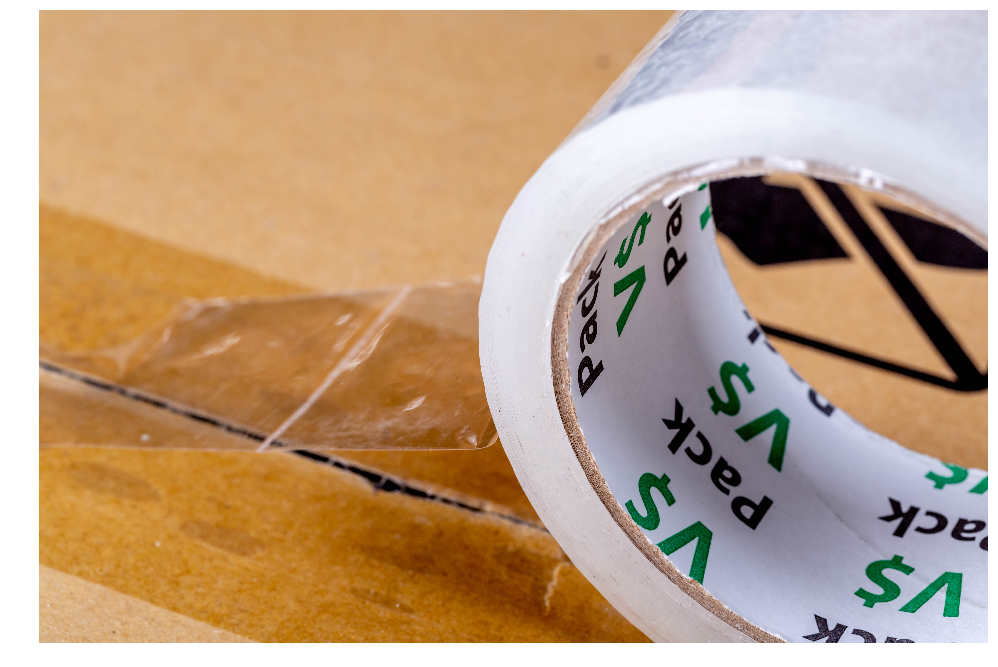

In [48]:
if not os.path.exists(flickr_dataset_path):
    print("Creating Dataset Folder!")
    os.mkdir(flickr_dataset_path)

accept_button = widgets.Button(description="Accept!")
decline_button = widgets.Button(description="Decline!")
show_button = widgets.Button(description="Show!")

img = None
photo = None

banned_tags = set([
    "bw", "blackandwhite", "monochrome", "marantoni2004", "marantoni", "secondlife", "tokyo",
    "strawberryfair", "wwwbreakoutbaselch", "motorcars", "crownstarimages", "nafiannaac"
])

def examine_next_image(b, accepted, skip=5):
    
    global img, photo, banned_tags
        
    clear_output()
    display(accept_button)
    display(decline_button)
    display(show_button)
    
    # if accepted, downsample the last image save it as png
    if img is not None and accepted:
        
        # Can reconstruct image id from
        # http://farm{farm-id}.static.flickr.com/{server-id}/{id}_{secret}.(jpg|gif|png)
        folder_name = SEARCH_TEXT.replace(',','_')
        folder_path = flickr_dataset_path + "/" + folder_name
        
        file_name = "{}/{}/{}_{}_{}_{}.png".format(flickr_dataset_path,
                                                   folder_name,
                                                   photo['farm'],
                                                   photo['server'],
                                                   photo['id'],
                                                   photo['secret'])
        
        if not os.path.exists(folder_path):
            os.mkdir(folder_path)
            
        
        if os.path.exists(file_name):
            print("{} already exists!".format(file_name))
        
        else:
            print("Saving {}!".format(file_name))
            w, h = img.size
            
            max_dim = np.maximum(w, h)
            
            ratio = np.maximum(2, max_dim / 2000)
            
            # Downsample by ratio
            resized = np.array(img.resize((np.floor(w / ratio).astype(np.int32), 
                                           np.floor(h / ratio).astype(np.int32))))

            imsave(file_name, resized)
            
            img = None
    
    # Get the next photo
    if len(photos) == 0:
        print("No more photos left in response!")
        return
    
    else:
        print("{} / {} photos left!".format(len(photos), num_photos))
    
    for i in range(skip):
        photo = photos.pop()
    
    while 'url_o' not in photo or \
            "title" not in photo or \
            int(photo['width_o']) < 1200 or \
            int(photo['height_o']) < 1200 or \
            any([tag in banned_tags for tag in photo["tags"].split()]):

        photo = photos.pop()
    
    print("{} photos in dataset!".format(len(glob.glob(flickr_dataset_path + "/*/*.png"))))
    print("Title: {}\nDims: {}x{}".format(photo["title"], photo["width_o"], photo["height_o"]))
    print()
    print("Tags: {}".format(photo["tags"]))
    
examine_next_image(None, False)

def show_image(b):
    global img, photo
    
    response = requests.get(photo['url_o'])
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(17, 17))
    plt.axis('off')
    plt.imshow(np.asarray(img))

accept_button.on_click(lambda b: examine_next_image(b, True))
decline_button.on_click(lambda b: examine_next_image(b, False))
show_button.on_click(show_image)
